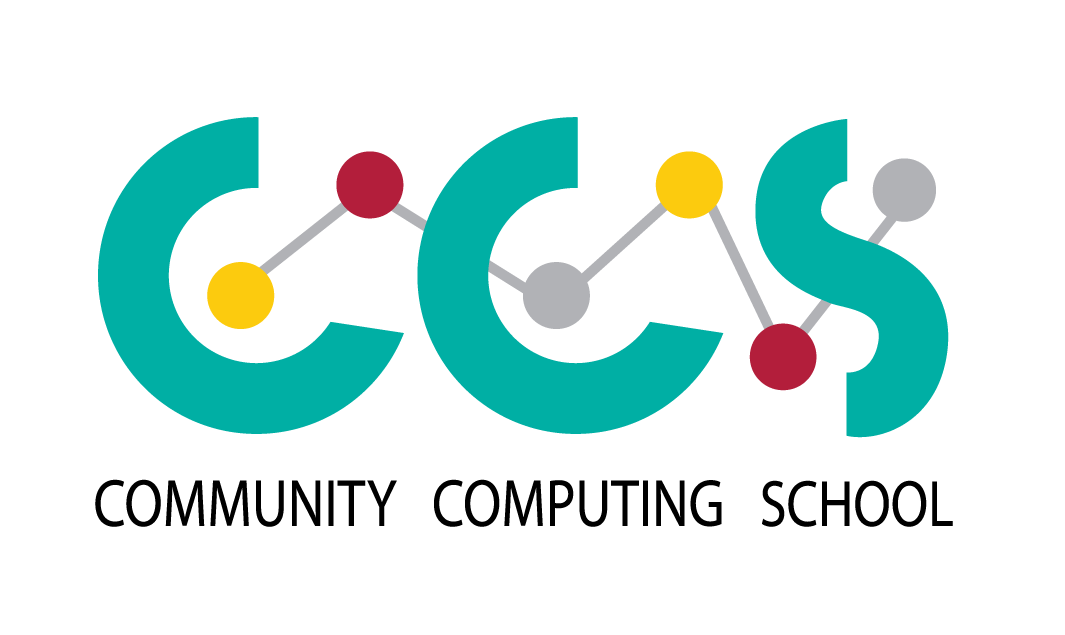

# Spot-Check Classification with AutoML

## Import Libraries

In [34]:
from datetime import datetime
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy.stats import shapiro, normaltest
from tpot import TPOTClassifier
from hpsklearn import HyperoptEstimator, pca, min_max_scaler, standard_scaler
from hpsklearn import xgboost_classification, random_forest, ada_boost, gradient_boosting, extra_trees
from hpsklearn import svc, svc_linear, svc_rbf, svc_poly, svc_sigmoid, liblinear_svc
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hyperopt import tpe, hp
from pycaret.classification import * 
from pycaret.datasets import get_data

## Load Dataset

In [2]:
df = pd.read_csv('../DataSet/heart_disease_clean.csv')

In [3]:
df.shape

(303, 14)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,male,typical angina,145.0,233.0,True,2.0,150.0,no,2.3,downsloping,0.0,6.0,0
1,67.0,male,asymptomatic,160.0,286.0,False,2.0,108.0,yes,1.5,flat,3.0,3.0,1
2,67.0,male,asymptomatic,120.0,229.0,False,2.0,129.0,yes,2.6,flat,2.0,7.0,1
3,37.0,male,non-anginal pain,130.0,250.0,False,0.0,187.0,no,3.5,downsloping,0.0,3.0,0
4,41.0,female,atypical angina,130.0,204.0,False,2.0,172.0,no,1.4,upsloping,0.0,3.0,0


## Result of EDA & Data Preprocessing

In [5]:
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
nominal_features = ['sex', 'cp', 'exang', 'slope', 'thal', 'fbs', 'restecg']

In [6]:
dummies = pd.get_dummies(df[nominal_features], drop_first=True)
df = df.drop(nominal_features, axis=1)
df = pd.concat([df, dummies], axis=1)

## Split Data Set

In [8]:
X = df.drop("num", axis=1)
y = df["num"]

In [10]:
y = LabelEncoder().fit_transform(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

## TPOT AutoML

In [14]:
rs = RobustScaler()
X_scaled = rs.fit_transform(X)

In [17]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")

# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
tpot = TPOTClassifier(cv=cv, scoring='accuracy', 
                       verbosity=2, random_state=1, n_jobs=-1) 
# perform the search
tpot.fit(X_scaled, y)

model = tpot.fitted_pipeline_

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))
print (f"Job Ended at: {fin_time}")

Job Started at: 2021-01-10 23:35:18.445177


Version 0.11.6.post3 of tpot is outdated. Version 0.11.7 was released 4 days ago.



Generation 1 - Current best internal CV score: 0.8471684587813619

Generation 2 - Current best internal CV score: 0.8471684587813619

Generation 3 - Current best internal CV score: 0.8515053763440859

Generation 4 - Current best internal CV score: 0.8515053763440859

Generation 5 - Current best internal CV score: 0.8515053763440859

Generation 6 - Current best internal CV score: 0.8515053763440859

Generation 7 - Current best internal CV score: 0.8515053763440859

Generation 8 - Current best internal CV score: 0.8515053763440861

Generation 9 - Current best internal CV score: 0.8558781362007167

Generation 10 - Current best internal CV score: 0.8558781362007167

Generation 11 - Current best internal CV score: 0.8614695340501792

Generation 12 - Current best internal CV score: 0.8614695340501792

Generation 13 - Current best internal CV score: 0.8614695340501792

Generation 14 - Current best internal CV score: 0.8614695340501792

Generation 15 - Current best internal CV score: 0.861469

In [18]:
#export the best model
tpot.export('tpot_heart_disease_best_model.py')

In [23]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from tpot.export_utils import set_param_recursive

In [24]:
exported_pipeline = make_pipeline(
    PCA(iterated_power=6, svd_solver="randomized"),
    RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=0.45, n_estimators=100), step=0.7500000000000001),
    LinearSVC(C=20.0, dual=True, loss="squared_hinge", penalty="l2", tol=0.01)
)

In [25]:
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 1)

In [26]:
exported_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca',
                 PCA(iterated_power=6, random_state=1,
                     svd_solver='randomized')),
                ('rfe',
                 RFE(estimator=ExtraTreesClassifier(criterion='entropy',
                                                    max_features=0.45,
                                                    random_state=1),
                     step=0.7500000000000001)),
                ('linearsvc', LinearSVC(C=20.0, random_state=1, tol=0.01))])

In [27]:
results = exported_pipeline.predict(X_test)

In [28]:
results

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0])

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [30]:
print(classification_report(y_test, results))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56        49
           1       0.47      0.45      0.46        42

    accuracy                           0.52        91
   macro avg       0.51      0.51      0.51        91
weighted avg       0.51      0.52      0.52        91



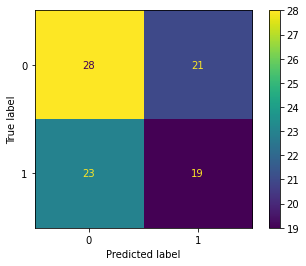

In [31]:
plot_confusion_matrix(exported_pipeline,X_test, y_test)

## hpsklearn AutoML

In [32]:
rs = RobustScaler()
X_train_scaled = rs.fit_transform(X_train)
X_test_scaled = rs.transform(X_test)

In [36]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
accuracy = 0
best_model = None
#for i in range(100):
    #print (i)
model = HyperoptEstimator(  classifier= any_classifier('cla'), 
                                preprocessing= any_preprocessing('pre'), 
                                algo=tpe.suggest, 
                                max_evals=50, 
                                trial_timeout=5000)
    # perform the search
model.fit(X_train_scaled, y_train)
acc = model.score(X_test_scaled, y_test)
    #if acc > accuracy:
        #accuracy = acc
        #best_model = model
        #print (accuracy)

fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))
print (f"Job Ended at: {fin_time}")

Job Started at: 2021-01-11 10:08:56.844226
 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

job exception: __init__() got an unexpected keyword argument 'n_iter'



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]


TypeError: __init__() got an unexpected keyword argument 'n_iter'

## PyCaret AutoML

### PyCaret Setup

In [43]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
#fold_strategy = 'kfold' Default = 'stratifiedkfold'
clf = setup(data = df, target = 'num', session_id=123,
            data_split_stratify = True,
            #normalize = True, 
            #normalize_method = 'minmax',
            #transformation = True, 
            #transformation_method = 'quantile',
            pca = True,
            pca_method = 'incremental',
            feature_selection = True,
            feature_selection_threshold = 0.5,
            feature_selection_method = 'boruta'
            #remove_outliers = True,
            #outliers_threshold = 0.05,
            #fix_imbalance = True
           )
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))
print (f"Job Ended at: {fin_time}")

,Description,Value
0,session_id,123
1,Target,num
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(303, 17)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


Execution time :  0:00:11.787022
Job Ended at: 2021-01-11 10:13:15.209116


### Finding optimal model

In [44]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
top3_models = compare_models(n_select = 3)
best = compare_models()
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))
print (f"Job Ended at: {fin_time}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8346,0.8852,0.7644,0.8679,0.8081,0.6637,0.6726,0.0130
lr,Logistic Regression,0.8299,0.8822,0.7633,0.8648,0.8041,0.6541,0.6655,0.0210
ridge,Ridge Classifier,0.8299,0.0000,0.7533,0.8679,0.8015,0.6536,0.6637,0.0130
qda,Quadratic Discriminant Analysis,0.7968,0.8556,0.7422,0.8073,0.7674,0.5872,0.5956,0.0110
et,Extra Trees Classifier,0.7827,0.8578,0.7411,0.7915,0.7582,0.5600,0.5703,0.2060
nb,Naive Bayes,0.7781,0.8580,0.7622,0.7601,0.7561,0.5516,0.5574,0.0150
ada,Ada Boost Classifier,0.7639,0.8277,0.7533,0.7448,0.7446,0.5241,0.5300,0.0520
rf,Random Forest Classifier,0.7636,0.8614,0.7333,0.7583,0.7370,0.5218,0.5309,0.2520
catboost,CatBoost Classifier,0.7593,0.8552,0.6933,0.7825,0.7264,0.5126,0.5237,1.7200
lightgbm,Light Gradient Boosting Machine,0.7498,0.8443,0.7033,0.7590,0.7200,0.4936,0.5044,0.0200


Execution time :  0:09:44.442315
Job Ended at: 2021-01-11 10:24:07.066914


In [45]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
best_model = finalize_model(best)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))
print (f"Job Ended at: {fin_time}")

Job Started at: 2021-01-11 10:33:15.428354
Execution time :  0:00:08.547608
Job Ended at: 2021-01-11 10:33:23.975962


In [46]:
print (best_model)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
